# Model comparison to GLODAP along GO-SHIP Easy Ocean lines
This notebook shows a means of comparing MOM6 ocean model data to GLODAP data along the WOCE/GO-SHIP sections. GLODAP data are taken from the cruises used to construct the Easy Ocean lines, and interpolated **for visualization purposes only** using 3D interpolation. See [here](https://www.glodap.info/) for information on GLODAP, and [here](https://cchdo.ucsd.edu/products/goship-easyocean) for information on the Easy Ocean lines.

In [89]:
import pandas as pd
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import gfdl_utils as gu
import glob
import re
from scipy.interpolate import griddata

## Plot options
Specify a WOCE/GO-SHIP section line to look at, and a year range for the model.

In [90]:
line = 'P16'
time = '2010-2014'

## Read model data

In [91]:
pathDict = {'pp':'/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp',
            'out':'av'}
pathDict['ppname']='ocean_inert_z_1x1deg'
pathDict['time']=time
pathDict['local']='annual_5yr'
pathDict['add']='ann'

In [92]:
dsm = gu.core.open_frompp(**pathDict)

In [93]:
dsm

<xarray.Dataset>
Dimensions:     (time: 1, bnds: 2, z_l: 35, z_i: 36, lat: 180, lon: 360)
Coordinates:
  * time        (time) object 2012-07-02 12:00:00
  * z_l         (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * z_i         (z_i) float64 0.0 5.0 15.0 25.0 ... 5.75e+03 6.25e+03 6.75e+03
  * lat         (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon         (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * bnds        (bnds) float64 1.0 2.0
Data variables:
    time_bnds   (time, bnds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds    (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
    lon_bnds    (lon, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
    cfc11       (time, z_l, lat, lon) float32 dask.array<chunksize=(1, 35, 180, 360), meta=np.ndarray>
    cfc12       (time, z_l, lat, lon) float32 dask.array<chunksize=(1, 35, 180, 360), meta=np.ndarray>
    sf6         (time, z_l, lat, lon) float32 dask.array<chunksize=(1, 35, 180, 360), meta=np.ndarray>
    volcello    (time, z_l, lat, lon) float32 dask.array<chunksize=(1, 35, 180, 360), meta=np.ndarray>
    average_T1  (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    average_T2  (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    title:                 CM4_historical_c192_OM4p25
    associated_files:      areacello: 20100101.ocean_static.nc
    grid_type:             regular
    grid_tile:             N/A
    code_release_version:  19.1
    git_hash:              c97c1f6afab0df3545ee82c337d51accc4205bc3
    creationtime:          Tue Jan 31 21:20:49 2023
    hostname:              pp328
    history:               fregrid --standard_dimension --input_mosaic ocean_...
    comment:               FMS time averaging, version 3.0, precision=double
    filename:              ocean_inert_z_1x1deg.2010-2014.ann.nc

In [95]:
rolllon = dsm['lon'].roll(lon=180)
newlon = rolllon.where(rolllon<180,-1*(360-rolllon))
dsm = dsm.roll(lon=180).assign_coords({'lon':newlon})

In [417]:
gridpath = gu.core.get_pathstatic(pathDict['pp'],pathDict['ppname'])
grid = xr.open_dataset(gridpath)

rolllon = grid['lon'].roll(lon=180)
newlon = rolllon.where(rolllon<180,-1*(360-rolllon))
grid = grid.roll(lon=180).assign_coords({'lon':newlon})

## Read GLODAP data

In [418]:
rootdir = '/work/gam/glodap/'
filename = 'GLODAPv2.2022_Merged_Master_File.csv'
df = pd.read_csv(rootdir+filename,na_values=-9999)

/vftmp/Henri.Drake/pid913/ipykernel_21015/364509296.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(rootdir+filename,na_values=-9999)


## Read GO-SHIP Easy Ocean data

In [419]:
rootdir = glob.glob('/work/gam/GO-SHIP/gridded/*/'+line)[0]
# Get merged netcdf file
filename = line.lower()+'.nc'
path = '/'.join([rootdir,filename])
dso_nc = xr.open_dataset(path)
# And assign appropriately
if len(dso_nc['latitude'])==1:
    dimx = 'longitude'
elif len(dso_nc['longitude'])==1:
    dimx = 'latitude'

## Match GLODAP data with cruises used for Easy Ocean
(via the `expocode`)

In [420]:
# Get the relevant expocode
# NOTE This approach assumes that the all_years_used
# and the expocode attributes of the netcdf file have 
# the same number of entries listed, and that they are
# aligned in the same order
# I can probably implement some checks for this
years = re.findall(r'\d+', dso_nc.attrs['all_years_used'])
ecs = dso_nc.attrs['expocode'].split(',')

In [421]:
ecs_i = list(set(ecs) & set(list(df['G2expocode'].unique())))
print('Available cruise data : '+' '.join(ecs_i))

Available cruise data : 320620140320 33RO20150525 325020060213 325020080826 33RO20150410 32NM19800810


In [422]:
# Find year closest to model year
years_np = np.array([int(i) for i in years])
yearo = years[np.argmin(np.abs(dsm['time.year'].values-years_np))]
# Get corresponding expo code
ec = ecs[years.index(str(yearo))]

In [423]:
# Subset GLODAP data for corresponding cruise
cond = df['G2expocode']==''
for ec in ecs:
    cond += (df['G2expocode']==ec)
dfo = df[cond]

## Interpolate GLODAP data to Easy Ocean line

Using `LocStream` functionality in `xesfm.Regridder` (see [analysis cookbook](https://mom6-analysiscookbook.readthedocs.io/en/latest/notebooks/Comparing_to_section_data.html)).

In [438]:
import sectionate # only needed for `distance_on_unit_sphere` function here!

In [439]:
# generate finer resolution sections that follow coarse sections
def to_fine_section(lons, lats, spacing):
    new_lons, new_lats = np.array([]), np.array([])
    for i in range(len(lons)-1):
        section_length = np.rad2deg(sectionate.distance_on_unit_sphere(lats[i], lons[i], lats[i+1], lons[i+1]))
        Δlon, Δlat = tuple([δ*spacing/section_length for δ in [lons[i+1]-lons[i], lats[i+1]-lats[i]]])
        if Δlon!=0.:
            new_lons = np.append(new_lons, np.arange(lons[i], lons[i+1], Δlon))
        else:
            new_lons = np.append(new_lons, lons[i].values*np.ones_like(np.arange(lats[i], lats[i+1], Δlat)))
        if Δlat!=0.:
            new_lats = np.append(new_lats, np.arange(lats[i], lats[i+1], Δlat))
        else:
            new_lats = np.append(new_lats, lats[i].values*np.ones_like(np.arange(lons[i], lons[i+1], Δlon)))
    return new_lons, new_lats

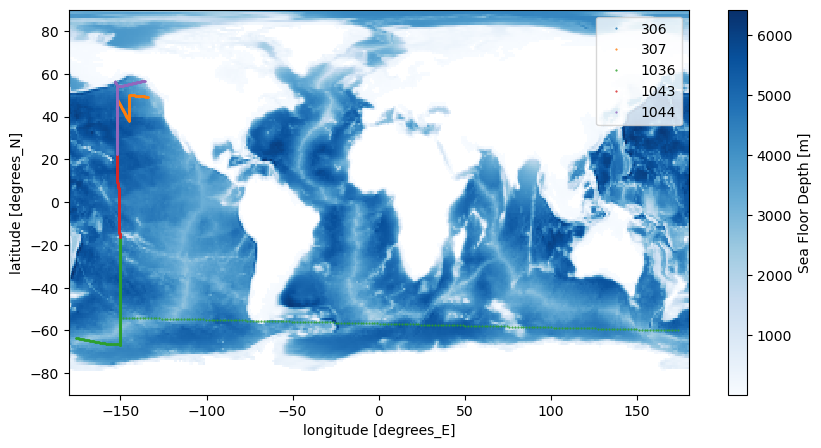

In [440]:
sections = {}

fig, ax = plt.subplots(1,1, figsize=(10, 5))
grid['deptho'].plot(ax=ax, cmap="Blues")

cond = np.isfinite(dfo['G2cfc12'])
for cruise in dfo[cond]['G2cruise'].unique():
    stations = dfo.loc[dfo['G2cruise']==cruise].groupby(['G2longitude', 'G2latitude']).mean(numeric_only=True)

    section_points = xr.Dataset(
        {'lon': xr.DataArray([stations.index[i][0] for i in range(len(stations))], dims=("location",)),
         'lat': xr.DataArray([stations.index[i][1] for i in range(len(stations))], dims=("location",))}
    )

    lons, lats = to_fine_section(section_points.lon, section_points.lat, 0.1)

    section = xr.Dataset(
        {'lon': xr.DataArray(lons, dims=("location",)),
         'lat': xr.DataArray(lats, dims=("location",))}
    )

    sections[cruise] = section
    ax.plot(section['lon'], section['lat'], ".", markersize=1., label=cruise)
ax.legend()

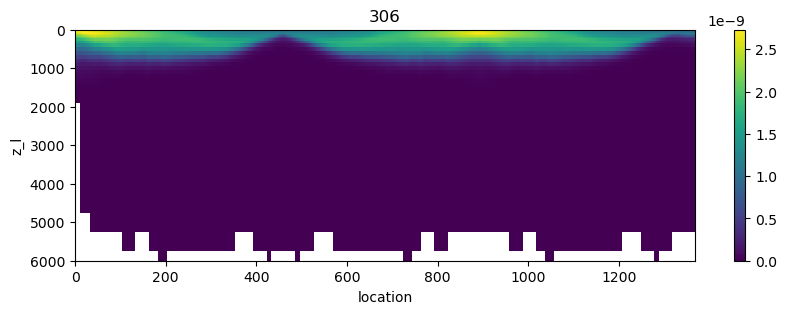

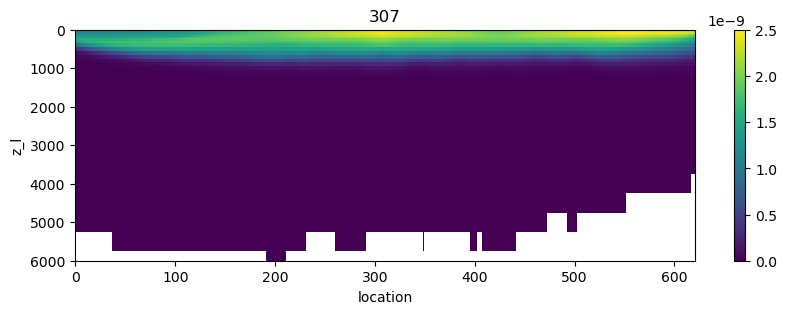

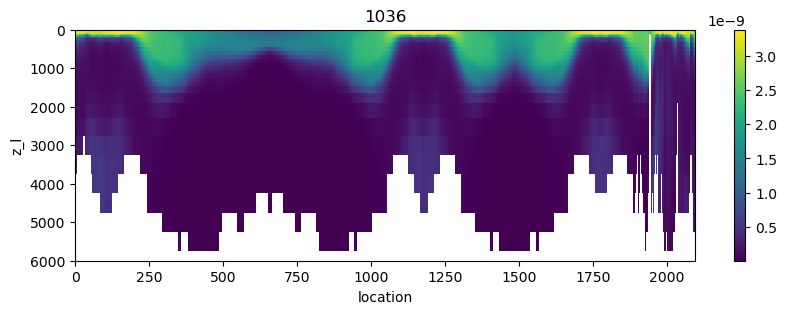

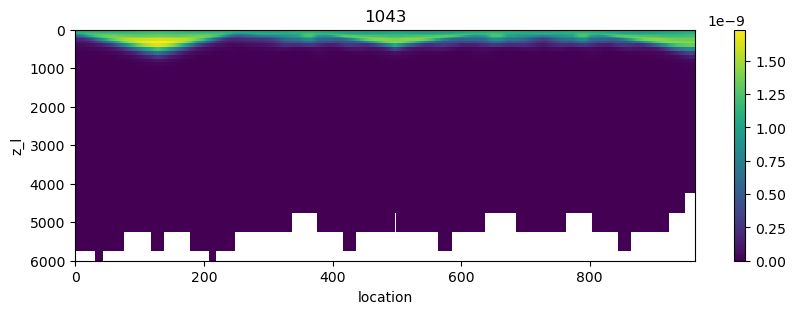

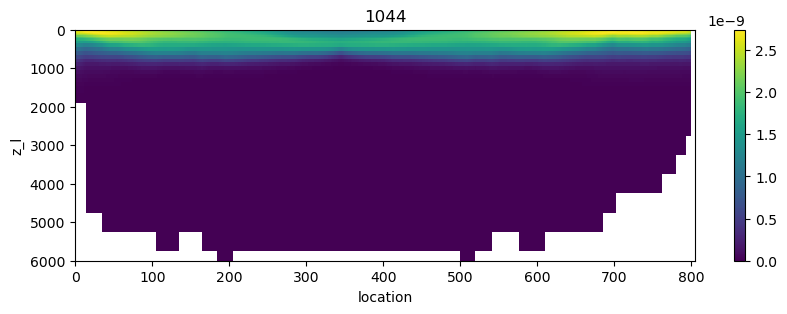

In [441]:
import xesmf as xe

for cruise, section in sections.items():
    regridder = xe.Regridder(grid, section, "bilinear", locstream_out=True)
    cfc12 = regridder(dsm['cfc12'])
    plt.figure(figsize=(10, 3))
    cfc12.plot()
    plt.title(cruise)
    plt.ylim(6000, 0)

# HFD: Have not touched code below at all yet

In [187]:
# Subset only to locations where measurements were made
cond = np.isfinite(dfo['G2cfc12'])
v = dfo[['G2longitude','G2latitude','G2depth']][cond].to_numpy()
d = dfo['G2cfc12'][cond].values

xi, yi, zi = np.meshgrid(dso_nc['longitude'].values,
                         dso_nc['latitude'].values,
                         dso_nc['pressure'].values)
vi = np.vstack((xi.ravel(), yi.ravel(), zi.ravel())).transpose()

rbf = RBFInterpolator(v, d, kernel="thin_plate_spline",smoothing=1000)
di = rbf(vi)

di = di.reshape(xi.shape)
tmp = dso_nc['temperature'].isel(gridded_section=0).squeeze()
dsg = xr.Dataset()
dsg['cfc12'] = tmp.copy(data=di.squeeze().transpose()).where(np.isfinite(tmp))

## Interpolate model data to Easy Ocean line

In [188]:
dsmo = dsm.interp({'lat':dso_nc['latitude'],'lon':dso_nc['longitude'],'z_l':dso_nc['pressure']}).squeeze()

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


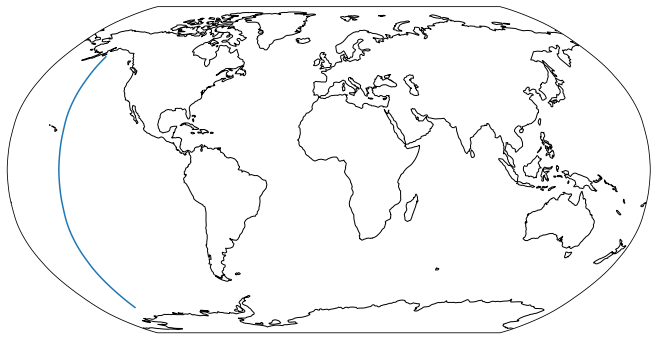

In [189]:
if dimx=='longitude':
    x=dso_nc['longitude'].values
    y=dso_nc['latitude']*xr.ones_like(dso_nc['longitude']).squeeze().values
elif dimx=='latitude':
    x=dso_nc['longitude']*xr.ones_like(dso_nc['latitude']).squeeze().values
    y=dso_nc['latitude'].values
    
fig,ax=plt.subplots(figsize=(12,6),subplot_kw={'projection':ccrs.Robinson()})
ax.set_global()
ax.plot(x,y,transform=ccrs.PlateCarree())
ax.coastlines()

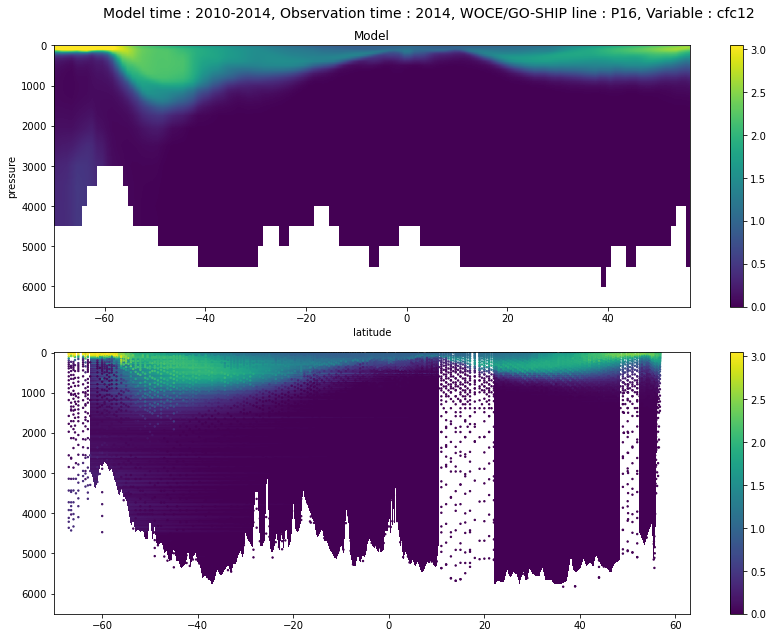

In [194]:
variable = 'cfc12'
conversion = 1e12/1035
x = dsg[dimx]
y = dsg['pressure']
zo = dsg[variable]
zm = dsmo[variable]*conversion

fig,ax = plt.subplots(figsize=(12,9),nrows=2)

fig.suptitle('Model time : '+time+
              ', Observation time : '+str(yearo)+
              ', WOCE/GO-SHIP line : '+line+
              ', Variable : '+variable,
            fontsize=14)

im = ax[0].pcolormesh(x,y,zm,shading='auto')
ax[0].invert_yaxis()
ax[0].set_title('Model')
ax[0].set_xlabel(dimx)
ax[0].set_ylabel('pressure')
plt.colorbar(im,ax=ax[0])

imp = ax[1].pcolormesh(x,y,zo,shading='auto')
ax[1].invert_yaxis()
# Add original observations
ims = ax[1].scatter(v[:,1],v[:,2],c=d,s=2)
clims = list(imp.get_clim())
clims[0]=0
imp.set_clim(clims)
ims.set_clim(clims)
im.set_clim(clims) # Set model lims to obs
plt.colorbar(imp,ax=ax[1])

fig.tight_layout()